In [19]:
import numpy as np
import qutip
import sympy as sp 
from CoupledQuantumSystems.drive_symbo import DriveTermSymbolic, JAX_AVAILABLE
from CoupledQuantumSystems.drive import DriveTerm, square_pulse_with_rise_fall_envelope
from CoupledQuantumSystems.pulse_shapes_symbo import gaussian_pulse, square_pulse_with_rise_fall
from CoupledQuantumSystems import pulse_shapes_symbo as pss
import matplotlib.pyplot as plt

# Imports from user example
import pickle
from tqdm import tqdm
from copy import deepcopy
import scqubits
from CoupledQuantumSystems.systems import TransmonOscillatorSystem
from CoupledQuantumSystems.evo import ODEsolve_and_post_process

# Please note that the unit is ns and GHz, no need to worry about the numbers, they are fine
# --- Simulation setup from user example --- 
max_ql = 3
max_ol = 10
t_tot = 100 # Made float for linspace
amp_val = 0.4 # Renamed from amp to amp_val to avoid conflict with pss.amp
dt_val = 0.05 # Define dt for the simulation and pulse
num_points = 101
tlist_sim = np.linspace(0, t_tot, num_points)

ncut = 110
tmon_EJ = 22.867925499169555
tmon_EC = 0.2492658230114663
tmon_ng = 0.3
Er = 20.88428612709732
g = 0.599684130648041
kappa_val = 0.022

qbt = scqubits.Transmon(EJ=tmon_EJ, EC=tmon_EC, ng=tmon_ng, ncut=ncut, truncated_dim=max_ql)
osc = scqubits.Oscillator(E_osc=Er, truncated_dim=max_ol, l_osc=1.0)

system = TransmonOscillatorSystem(
    qbt=qbt,
    osc=osc,
    g_strength=g,
    kappa=kappa_val,
    products_to_keep=[[ql, ol] for ql in range(max_ql) for ol in range(max_ol)],
)

if not system.product_to_dressed:
    print("Warning: system.product_to_dressed is empty. Generating default mapping.")
    system.generate_default_mapping()

key_00 = (0,0)
key_01 = (0,1)
key_10 = (1,0)
key_11 = (1,1)

w_d = ((system.evals[system.product_to_dressed[key_01]] - system.evals[system.product_to_dressed[key_00]]) + \
        (system.evals[system.product_to_dressed[key_11]] - system.evals[system.product_to_dressed[key_10]])) / 2

e_ops = [qutip.ket2dm(qutip.basis(max_ql * max_ol, system.product_to_dressed[(ql, ol)])) 
            for ql in range(max_ql) for ol in range(max_ol)] + [system.a.dag() * system.a]


current_t_start = 0.0
current_t_rise = 1e-13 #small number to avoid division by zero
current_t_square = t_tot # Make the square part last for the whole simulation for this test
# current_t_square = 1e9 # User's original very long pulse (basically always on, but it doesn't matter because the total duration is set by the tlist / tspan)

# Symbolic parameters for the PURE shape (using canonical symbols from pss)
# These are parameters for the shape itself, not overall amplitude or phase.
shape_specific_params = {
    pss.start: current_t_start, # Start time of the pulse shape
    pss.rise: current_t_rise,   # Rise time for the shape
    pss.square: current_t_square/dt_val # Duration of the square part of the shape
}

drive_term_sim = DriveTermSymbolic(
    driven_op=system.driven_operator,
    pulse_type="square_pulse_with_rise_fall", # Specify the type of pure shape
    symbolic_params=shape_specific_params,   # Pass shape-specific parameters
    
    amplitude=amp_val,                       # Overall amplitude for the envelope
    duration=t_tot,          # Total duration of this pulse instance for Qiskit
    envelope_angle=0.0,                      # Overall phase for the complex envelope
    
    modulation_freq=w_d,
    phi=0.0, # Carrier phase
    pulse_id="square_pulse_symbo_test",
    dt=dt_val                                # Time step for Qiskit sample conversion
)

# --- For QuTiP comparison (using old DriveTerm) ---
# Adjust args for the old square_pulse_with_rise_fall_envelope if its definition of t_start is implicit
# The old one takes 't_start', 't_rise', 't_square', 'amp'.
# It internally calculates t_fall_start and t_end based on these.
# Its 't_start' corresponds to pss.start.
qutip_pulse_args = {
    'amp': amp_val/(2*np.pi), # Note: old envelope might have 2*pi scaling, new pure shape does not.
                    # The 'amplitude' in DriveTermSymbolic is the final scale factor.
                    # If square_pulse_with_rise_fall_envelope includes 2*pi, amp_val here should be 1/(2*pi) for same field strength
                    # Let's assume square_pulse_with_rise_fall_envelope expects amp for the final field, like DriveTermSymbolic.amplitude
    't_start': current_t_start,
    't_rise': current_t_rise,
    't_square': current_t_square,
}

drive_term_qutip = DriveTerm(
    driven_op=system.driven_operator,
    pulse_shape_func=square_pulse_with_rise_fall_envelope, # Old numerical envelope
    pulse_shape_args=qutip_pulse_args,
    modulation_freq=w_d,
    phi=0.0, # Carrier phase for the old DriveTerm
    pulse_id="square_pulse_qutip_test",
)
# --- End QuTiP comparison setup ---

initial_state_qobj = qutip.ket2dm(qutip.basis(max_ql * max_ol, system.product_to_dressed[key_00]))

print("\n--- Running Symbolic/Qiskit Dynamics Test ---")
print(f"DriveTermSymbolic details:")
print(f"  pulse_type: {drive_term_sim.pulse_type}")
print(f"  amplitude: {drive_term_sim.amplitude}")
print(f"  duration (for Qiskit): {drive_term_sim.duration*1e9:.3f} ns")
print(f"  envelope_angle: {drive_term_sim.envelope_angle}")
print(f"  dt (for Qiskit): {drive_term_sim.dt*1e9:.3f} ns")
print(f"  symbolic_params (shape-specific):")
for k,v in drive_term_sim.symbolic_params.items():
    val_str = f"{v*1e9:.3f} ns" if isinstance(v, float) and v !=0 else str(v)
    print(f"    {k.name}: {val_str}")
print(f"  modulation_freq: {drive_term_sim.modulation_freq:.3f} GHz, carrier_phi: {drive_term_sim.phi:.3f} rad")

print(f"Running ODEsolve_and_post_process with method qiskit_dynamics...")
print(f"  Initial state type: {type(initial_state_qobj)}")
print(f"  Static Hamiltonian type: {type(system.diag_hamiltonian)}")
print(f"  Drive terms: {[drive_term_sim]}")
print(f"  C_ops: {[kappa_val * system.a]}")
print(f"  E_ops count: {len(e_ops)}")
print(f"  Rotating frame type: {type(system.diag_hamiltonian)}")
print(f"  RWA carrier freqs: {[w_d]}")
print(f"  tlist length: {len(tlist_sim)}")

result = ODEsolve_and_post_process(
    y0=initial_state_qobj,
    tlist=tlist_sim,
    static_hamiltonian=system.diag_hamiltonian,
    drive_terms=[drive_term_sim],
    c_ops=[kappa_val * system.a],
    e_ops=e_ops,
    store_states=True,
    method='qiskit_dynamics',
    qiskit_solver_method='jax_odeint', # Ensure JAX solver is requested
    rotating_frame=system.diag_hamiltonian,
    rwa_carrier_freqs=[w_d],
    print_progress=True,
    dt_val = dt_val,
)

print("Symbolic/Qiskit Dynamics simulation finished.")
if result:
    print(f"  Result contains {len(result.states)} states.")
    if result.expect and result.expect[0] is not None : # Check first e_op result
        # Expectation values might be a list of arrays or a 2D array
        try:
            print(f"  Result expectation values shape for first e_op: {np.array(result.expect[0]).shape}")
        except Exception as e:
            print(f"  Could not determine shape of first e_op result: {e}")
    else:
        print("  Result expectation values are empty or None.")
        
# --- QuTiP Comparison Run ---
print("\n--- Running QuTiP Comparison Test ---")
results_qutip = ODEsolve_and_post_process(
    y0=initial_state_qobj,
    tlist=tlist_sim,
    static_hamiltonian=system.diag_hamiltonian,
    drive_terms=[drive_term_qutip],
    c_ops=[kappa_val * system.a],
    e_ops=e_ops,
    store_states=True,
    method='qutip.mesolve', # Explicitly QuTiP
    print_progress=True
)
print("QuTiP simulation finished.")
if results_qutip:
    print(f"  QuTiP Result contains {len(results_qutip.states)} states.")

# Comparison
if result and results_qutip and result.states and results_qutip.states:
    print("\n--- Comparison ---")
    if len(result.states) == len(results_qutip.states):
        # Compare final states
        final_state_symbo = result.states[-1]
        final_state_qutip = results_qutip.states[-1]
        if isinstance(final_state_symbo, qutip.Qobj) and isinstance(final_state_qutip, qutip.Qobj):
                fidelity = qutip.fidelity(final_state_symbo, final_state_qutip)**2
                trace_dist = qutip.tracedist(final_state_symbo, final_state_qutip)
                print(f"  Fidelity between final states (symbo vs qutip): {fidelity:.6f}")
                print(f"  Trace distance between final states: {trace_dist:.6g}")
                if np.allclose(final_state_symbo.full(), final_state_qutip.full(), atol=1e-5): # Relaxed tolerance
                    print("  Final states are close (allclose check passed with atol=1e-5).")
                else:
                    print("  WARNING: Final states differ significantly.")
        else:
            print("  Could not compare final states: Not both Qobj.")
    else:
        print(f"  State list lengths differ: Symbolic ({len(result.states)}) vs QuTiP ({len(results_qutip.states)}). Cannot compare final states directly.")
else:
    print("  Skipping comparison: one or both results/states are missing.")



--- Running Symbolic/Qiskit Dynamics Test ---
DriveTermSymbolic details:
  pulse_type: square_pulse_with_rise_fall
  amplitude: 0.4
  duration (for Qiskit): 100000000000.000 ns
  envelope_angle: 0.0
  dt (for Qiskit): 50000000.000 ns
  symbolic_params (shape-specific):
    start: 0.0
    rise: 0.000 ns
    square: 2000000000000.000 ns
  modulation_freq: 20.893 GHz, carrier_phi: 0.000 rad
Running ODEsolve_and_post_process with method qiskit_dynamics...
  Initial state type: <class 'qutip.qobj.Qobj'>
  Static Hamiltonian type: <class 'qutip.qobj.Qobj'>
  Drive terms: [DriveTermSymbolic(driven_op=Quantum object: dims = [[30], [30]], shape = (30, 30), type = oper, isherm = True
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+1.77643795e-02j
   0.00000000e+00+2.72989731e-06j  0.00000000e+00-9.99720564e-01j
   0.00000000e+00+1.76875550e-07j  0.00000000e+00+1.28492436e-05j
   0.00000000e+00-7.80725351e-10j  0.00000000e+00-6.10337369e-07j
   0.00000000e+00-5.90632487e-09j  0.000

 /home/kai/miniconda3/envs/qiskit/lib/python3.10/site-packages/matplotlib/cbook.py: 1719ComplexWarning: Casting complex values to real discards the imaginary part
 /home/kai/miniconda3/envs/qiskit/lib/python3.10/site-packages/matplotlib/cbook.py: 1355

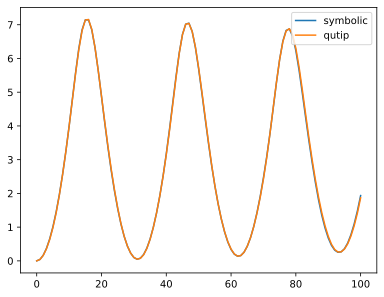

In [20]:
plt.plot(result.expect[-1],label='symbolic')
plt.plot(results_qutip.expect[-1],label='qutip')
plt.legend()

 /home/kai/miniconda3/envs/qiskit/lib/python3.10/site-packages/matplotlib/cbook.py: 1719ComplexWarning: Casting complex values to real discards the imaginary part
 /home/kai/miniconda3/envs/qiskit/lib/python3.10/site-packages/matplotlib/cbook.py: 1355

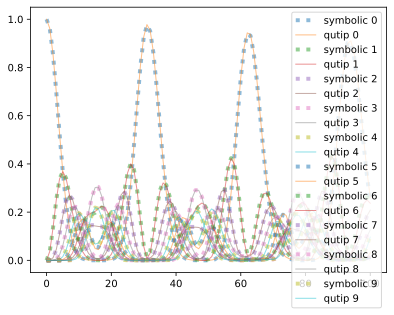

In [22]:
for ol in range(max_ol):
    plt.plot(result.expect[ol],label=f'symbolic {ol}',alpha=0.5,linewidth=4,linestyle=':')
    plt.plot(results_qutip.expect[ol],label=f'qutip {ol}',alpha=0.5,linewidth=1)
plt.legend()